In [2]:
%load_ext autoreload
%autoreload 2

In [55]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import sys
import matplotlib.pyplot as plt
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [4]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Colouring data & results\\"
proj_crs = "EPSG:3006"

In [10]:
place = 'Göteborgs Stad'
#place_gdf = ox.geocode_to_gdf(place).to_crs(proj_crs)

# based on https://commons.wikimedia.org/wiki/File:Metropolitan_Gothenburg_ver.3.PNG
place_gdf = gpd.read_file('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index\\#Example Notebooks\\Goteborg\\Goteborg_metropolitan_dissolve.gpkg', crs="EPSG:4326").to_crs(proj_crs)

<AxesSubplot: >

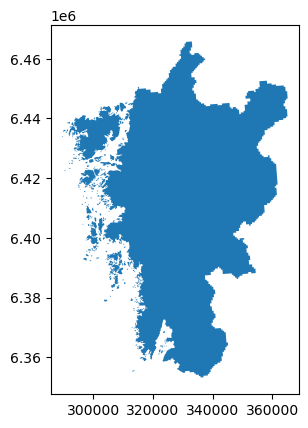

In [11]:
# check that we have the right area
place_gdf.geometry.plot()

## Import Data

Data sources:
1. OSM POIs
5. Employment data - find govt source

In [59]:
poi_dictionary = {
    'employment':{
        'category':['employment']
    },
    'shopping':{
        'shop':['bakery', 'clothes', 'supermarket', 'mall', 'greengrocer',
                'seafood', 'wine', 'butcher','convenience',
                'beverages', 'alcohol', 'bicycle_shop', 'department_store', 
                'doityourself', 'beauty_shop', 'outdoor_shop', 
                'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                'car_dealership', 'furniture_shop', 'sports_shop',
                'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
        # possibly we could pick up all shop=True excluding a few. but not sure how
        # and many options to exclude
        'amenity':['marketplace'],
        'building':['kiosk', 'supermarket',],
    },
    'errands':{
        'amenity':['atm','bank','courthouse','post_box', 'post_office',
                   'clinic', 'dentist', 'doctors', 'hospital',
                   'pharmacy', 'veterinary', 'travel_agent',
                   'place_of_worship'],
        'shop':['optician', 'hairdresser', 'laundry',],
        'healthcare':['physiotherapist'],
        'office':['government'], #### further refine ?
    },
    'recreation':{
        'leisure':['dog_park', 'ice_rink', 'park', 'pitch', 'playground',
                   "fitness_centre","sports_centre", 'stadium', 'swimming_pool',
                   'swimming_area', 'track', 'water_park','golf_course',],
        'club':['social'],
        'amenity':['bar', 'biergarten', 'cafe', 'fast_food', 'food_court',
                   'ice_cream', 'pub', 'restaurant', 'nightclub',
                   'library', 'arts_centre', 'cinema', 'community_centre',
                   'social_centre', 'theatre',],
        'building':['stadium', 'castle', 'ruins',],
        'tourism':['aquarium', 'artwork', 'attraction', 'gallery',
                   'museum', 'picnic_site', 'theme_park', 'viewpoint',
                   'zoo'],
        'natural':['beach'],
    },
    'education':{
        'amenity':['college', 'kindergarten', 'music_school',
                   'school', 'university', 'childcare'],
    },
    'grocery':{
        'category':['grocery']
    }
}

In [13]:
osm_pois = poi_downloader(place_gdf, poi_dictionary, proj_crs)

In [14]:
len(osm_pois[(osm_pois['shop']=='supermarket') | 
             (osm_pois['amenity']=='marketplace') | 
             (osm_pois['shop']=='greengrocer')])

228

### Add grocery store data

In [5]:
# import grocery_stores.gpkg from Data/Sweden
grocery_stores = gpd.read_file('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\Sweden\\grocery_stores.gpkg').to_crs(proj_crs)

In [49]:
# add category column, all values 'grocery' to grocery_stores
grocery_stores['category'] = 'grocery'
# create categories for other types of pois to avoid inaccurate duplicate removal
osm_pois['category'] = osm_pois['shop']
osm_pois['category'] = osm_pois['category'].fillna(osm_pois['amenity']).fillna(osm_pois['leisure']).fillna(osm_pois['building']).fillna(osm_pois['tourism']).fillna(osm_pois['natural']).fillna(osm_pois['office']).fillna(osm_pois['healthcare']).fillna(osm_pois['club'])
# add category column,  values 'grocery' to osm_pois relevant rows
osm_pois.loc[(osm_pois['shop']=='supermarket') | 
             (osm_pois['amenity']=='marketplace') | 
             (osm_pois['shop']=='greengrocer'),'category'] = 'grocery'
                                                                                        

In [56]:
combined_pois = remove_duplicate_pois([osm_pois, grocery_stores])

c:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as SWEREF99 TM (the single non-null crs provided).
  warnings.warn(


Removed 2.27% duplicate points from dataframes - 268 points


In [52]:
len(osm_pois[osm_pois['category']=='grocery']),  len(grocery_stores), len(combined_pois[combined_pois['category']=='grocery'])

(228, 342, 558)

In [54]:
# Seems that adding the grocery stores data has added 74 points overall
len(combined_pois) - len(osm_pois)

74

### Add employment points
Wasn't able to find this data yet for Göteborg. 

In [8]:
employment_centrs = gpd.read_file((folder + 
                        "Sydney Data\\Data\\Centroids employment MBs.gpkg")).to_crs(proj_crs)

employment_centrs['category'] = 'employment'
employment_centrs['geometry'] = employment_centrs.geometry.centroid

Need to remove potential overlap between different data sources (and inside some data sources). For now I'm not worrying about this when using only OSM data. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [21]:
#pois = pd.concat([osm_pois, employment_centrs])
pois = osm_pois

pois = gpd.clip(pois, place_gdf.to_crs(proj_crs))

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [61]:
poi_parameters = pd.read_csv(("poi_parameters.csv"), index_col=0)

In [62]:
poi_weights = poi_parameters['weight'].copy()

poi_lambdas = poi_parameters['diminishing_returns_constant'].copy()

poi_variables = poi_parameters['variable'].copy()

poi_nums = poi_parameters['num_pois'].copy()

poi_gammas = poi_parameters['distance_constant'].copy()

In [66]:
total = sum(poi_weights)
print("total: ", total, "\n", poi_weights)

total:  100 
 category
employment      0
education       0
shopping        0
errands         0
recreation      0
grocery       100
Name: weight, dtype: int64


In [25]:
# change this to match the column containting job counts in your employment dataframe
poi_variables.loc['employment'] = 'Jobs_count'
# change this to make employment score more accurate (higher number) or to reduce index calculation time (low number)
poi_nums.loc['employment'] = 1200

### Import network

Pandana expects edges to have a two item index based on the same IDs as the node index. (with thanks to https://github.com/shriv/accessibility-series/blob/master/Accounting%20for%20hills%20in%20accessibility%20analyses.ipynb)

In [69]:
#G = ox.graph_from_place(place, network_type='walk')
G = ox.graph.graph_from_polygon(place_gdf.to_crs('EPSG:4326').geometry[0], network_type='walk')

In [ ]:
osmnx.io.save_graphml(G, filepath=None, gephi=False, encoding='utf-8')

In [ ]:
G = osmnx.io.load_graphml(filepath=None, graphml_str=None, node_dtypes=None, edge_dtypes=None, graph_dtypes=None)

In [70]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [71]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

## Pandana network creation.

In [72]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
distance_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

### Pandana network querying. 

In [73]:
maximum_dist=2400

In [75]:
results_walk = there_index(distance_network, combined_pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)

No pois in category: employment
Finished category: employment
Maximum score: 0 out of 0
Finished category: education
Maximum score: 0.0 out of 0
Finished category: shopping
Maximum score: 0.0 out of 0


Note that the mean below is based on every network point, in the case of Greater Gothenburg this includes a lot of empty areas. To get a better indicator of average access for the population, need to produce population-weighted results as in section below.

In [32]:
max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index'])

(49.652403728064705, 19.26790760604494)

The current approach is to find up to x closest nodes for each category within the maximum distance. Then look up the attractiveness at each one (just count for most), apply a distance decay function to each distance, apply diminishing returns to the resulting total opportunity, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance including applying a decay function. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

## Export results

Reduce the number of decimal places before export, distances to destinations do not need to be below 1m.

In [40]:
def result_rounding(results):
    # reduces results size for export
    # score columns such as THERE_Index, employment_subtotal etc -> 3 decimal places
    # distance columns such as employment1 -> 0 decimal places (nearest metre)
    # avoid doing anything to connect_id, x or y
    rounding_dict = {**{k:3 for k in results.columns if "Index" in k or "." in k
                        and 'connect_id' not in k},
                     **{k:0 for k in results.columns if "Index" not in k and "." not in k
                        and k != 'x'
                        and k != 'y'}}
    return results.round(rounding_dict)

In [41]:
small_results = gpd.GeoDataFrame(result_rounding(results_walk), geometry = gpd.GeoSeries.from_xy(results_walk.x, results_walk.y, crs=proj_crs))

In [42]:
small_results.to_file(("Goteborg results walk 040723.gpkg"))

 ### Population weighted results

Import smallest statistical unit for which population data is available (meshblocks in Australia). Join this to the results (by population weighted centroid location if available, otherwise geometric centroid location). Then results can be graphed or visualised by population, giving a more accurate picture of the population access by walking.

In [ ]:
meshblocks = gpd.read_file(folder + "Sydney Data\\Data\\2016_NSW_MBs\\MB_2016_NSW.shp").to_crs(proj_crs)
meshblocks['MB_CODE16'] = meshblocks['MB_CODE16'].astype('int64')
meshblocks.geometry = meshblocks.centroid
population = pd.read_csv(folder + "Sydney Data\\Data\\2016_NSW_MBs\\2016 census mesh block counts.csv")
population = population.set_index('MB_CODE_2016')
meshblocks = meshblocks.join(population, on='MB_CODE16', how='left')

In [13]:
meshblocks_w = meshblocks.sjoin_nearest(small_results, how='left', rsuffix = 'w')
meshblocks_w = meshblocks_w.clip(place_gdf)

Population weighted average THERE index:

In [17]:
sum(meshblocks_w['Person_left']*meshblocks_w['THERE_Index'])/sum(meshblocks_w['Person_left'])

49.55207454204555

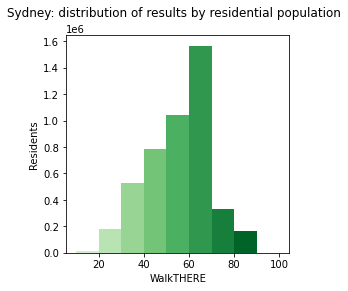

In [261]:
cm = plt.cm.Greens
bins=[10,20,30,40,50,60,70,80,90,100]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
fig.set_figwidth(4)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
fig.suptitle('Sydney: distribution of results by residential population')

n, bins, patches = plt.hist(join['THERE_Index'], weights = join['Person'], label='WalkTHERE',bins=bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/10 + 0.2)) # notice the i/25
    
plt.show()

In [61]:
meshblocks_w.to_file((folder + "Sydney Data\\Sydney MB results walk 190722.gpkg"))

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


### Visualise results

In [20]:
envelope = small_results.unary_union.envelope
envelope = gpd.GeoDataFrame({'geometry': envelope, 'convex_hull':[1]},crs=proj_crs)

water = gpd.read_file("C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\Australia waterways shape\\Australia water shape.shp")
water = water.to_crs(proj_crs)
water = water.clip(envelope)

Sydney = gpd.read_file("C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\ABS Data\\2016_GCCSA_aust_shape\\GCCSA_2016_AUST.shp").to_crs(proj_crs)
Sydney = Sydney.clip(envelope)

Text(0.5, 1.0, 'Sydney Meshblocks WalkTHERE - employment access')

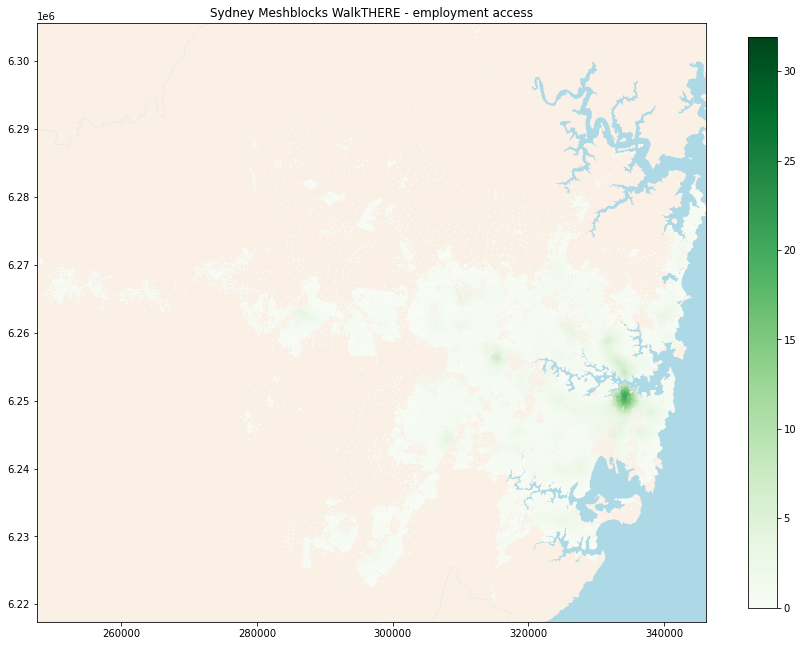

In [54]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_facecolor("lightblue")
ax.set_xmargin(0)
ax.set_ymargin(0)
small_results.plot(ax = ax, zorder=2, column="employment_31.9", 
                     cmap='Greens',markersize=1,vmin=0,vmax=31.9,legend=True, legend_kwds={'orientation': 'vertical','shrink':0.7})
Sydney.plot(ax = ax, zorder=1, color='linen')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=31.9))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
#cbar = fig.colorbar(sm)
plt.title("Sydney WalkTHERE - employment access")